<a href="https://colab.research.google.com/github/Tomori09/GuavaFruitDiseaseML/blob/main/GuavaFruitDiseaseML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
!pip install pandas
!pip install addict

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import os
import random
from addict import Dict
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
import opendatasets as od
import pandas as pd

In [ ]:
od.download("https://www.kaggle.com/datasets/asadullahgalib/guava-disease-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tomori09
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/asadullahgalib/guava-disease-dataset


100%|██████████| 1.52G/1.52G [00:11<00:00, 137MB/s]


#Methods

In [ ]:
def seed_everything(seed: int=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

#Baseline Configuration

In [ ]:
config = Dict({
    "train_path": "/content/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/train",
    "test_path": "/content/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/test",
    "validation_path": "/content/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val"
})

train_config = Dict({
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "epoch": 10,
    "seed": 2021,
    "image_shape": (128,128),
    "image_channels": 3,
    "num_workers": 0,
    "batch_size": 32,

    "augmentations": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        ToTensorV2()
    ]),

    "optimizer":{
        "type": "AdamW",
        "lr": 1e-4,
        "weight_decay": 1e-6
    }
})
seed_everything(train_config.seed)

In [ ]:
import os

print("Train path:", config.train_path)
print("Exists?", os.path.exists(config.train_path))

if os.path.exists(config.train_path):
  print("Number of classes:", len(os.listdir(config.train_path)))
  print("Subfolders:", os.listdir(config.train_path))

else:
  print("Path does not exist")

Train path: /content/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/train
Exists? True
Number of classes: 3
Subfolders: ['fruit_fly', 'Anthracnose', 'healthy_guava']


# Datasets

In [ ]:
class GuavaDiseaseDataset(Dataset):
    def __init__(self, path, augmentations=None, image_shape=(256, 256), channels="RGB"):
        self.__images_labels = []
        self.image_shape = image_shape
        self.channels = channels
        self.augmentations = augmentations

        if os.path.exists(path):
            self.labels = os.listdir(path)
            for label in self.labels:
                label_path = os.path.join(path, label)
                if os.path.isdir(label_path):
                    files = os.listdir(label_path)
                    for file in files:
                        if file.endswith("jpg") or file.endswith("png"):
                            image_path = os.path.join(label_path, file)
                            self.__images_labels.append((image_path, label))
                        else:
                            pass
                else:
                    pass

        else:
            pass

    def _load(self, path, channels="RGB"):
        width, height = self.image_shape
        loader = A.Compose([
            A.Resize(width=width, height=height),
            ToTensorV2(),
        ])

        image_array = np.array(Image.open(path).convert(channels))
        return loader(image=image_array)["image"]

    def __len__(self):
        return len(self.__images_labels)

    def __getitem__(self, index):
        path, label = self.__images_labels[index]
        image = self._load(path)

        if self.augmentations is not None:
            image = image.permute(1, 2, 0).numpy()
            image = self.augmentations(image=image)["image"]

        label = self.labels.index(label)

        return Dict({
            "image": image,
            "label": label,
        })


def collate_fn(batch):
    all_images, all_labels = [], []
    for item in batch:
        image = item.image
        label = item.label

        all_images.append(item.image.tolist())
        all_labels.append(label)

    return {
        "images": torch.tensor(all_images),
        "labels": torch.tensor(all_labels, dtype=torch.long)
    }

#Exploratory Data Analysis

In [ ]:
train_dataset = GuavaDiseaseDataset(config.train_path, train_config.augmentations, train_config.image_shape)

/tmp/ipython-input-242089222.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_dataset.labels, y=amount, palette=palette, ec="#000", linewidth=1.5, zorder=2, ax=ax)


NameError: name 'hide_spines' is not defined

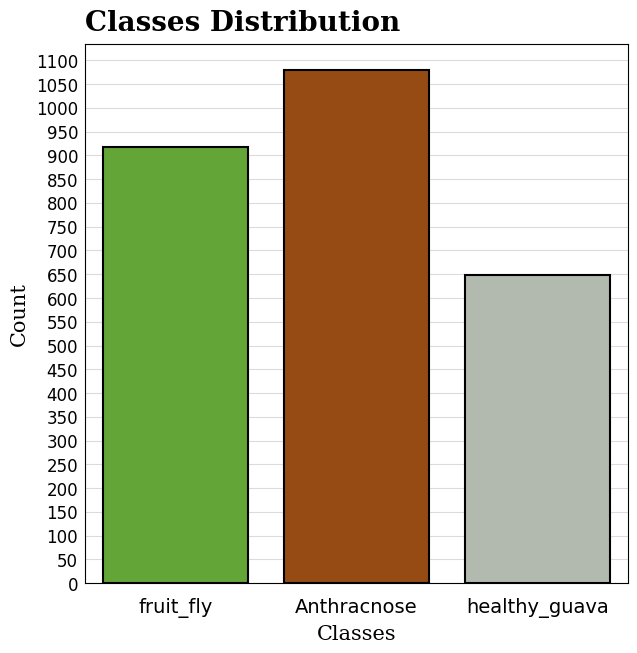

In [ ]:
if hasattr(train_dataset, "labels") and train_dataset.labels:
    label_paths = [os.path.join(config.train_path, label) for label in train_dataset.labels]
    label_files = [os.listdir(path) for path in label_paths]
    amount = [len(files) for files in label_files]

    palette = sns.color_palette(["#5FB924", "#AB4800", "#B2BBAC"])
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot()
    ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
    sns.barplot(x=train_dataset.labels, y=amount, palette=palette, ec="#000", linewidth=1.5, zorder=2, ax=ax)
    ax.xaxis.set_tick_params(labelsize=14, size=0, pad=10)
    ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
    ax.set_yticks(list(range(0, max(amount)+50, 50)))
    ax.set_title("Classes Distribution", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.01)
    ax.set_xlabel("Classes", fontsize=15, fontfamily="serif", labelpad=5)
    ax.set_ylabel("Count", fontsize=15, fontfamily="serif", labelpad=5)
    hide_spines(ax)
    plt.show()
else:
    print("[ERROR] train_dataset.labels not found. Check dataset path or reinitialize the dataset.")

In [ ]:
train_dataset = GuavaDiseaseDataset(path=config.train_path,
                                    augmentations=train_config.augmentations,
                                    image_shape=train_config.image_shape,
                                    channels=train_config.image_channels)

validation_dataset = GuavaDiseaseDataset(path=config.validation_path,
                                         augmentations=train_config.augmentations,
                                         image_shape=train_config.image_shape,
                                         channels=train_config.image_channels)

test_dataset = GuavaDiseaseDataset(path=config.test_path,
                                   augmentations=train_config.augmentations,
                                   image_shape=train_config.image_shape,
                                   channels=train_config.image_channels)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=train_config.batch_size,
                          num_workers=train_config.num_workers,
                          pin_memory=True,
                          shuffle=True,
                          collate_fn=collate_fn)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=train_config.batch_size*2,
                               num_workers=train_config.num_workers,
                               pin_memory=True,
                               shuffle=False,
                               collate_fn=collate_fn)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=train_config.batch_size*2,
                         num_workers=train_config.num_workers,
                         pin_memory=True,
                         shuffle=False,
                         collate_fn=collate_fn)

#Models

In [ ]:
#Load Model
alexnet = models.alexnet(pretrained = True)

#Freeze Layers
for param in alexnet.parameters():
    param.requires_grad = False

#Replace classifier output with num of classes
num_classes = len(train_dataset.labels)
alexnet.classifier[6] = nn.Linear(4096, num_classes)

#Move to Device
device = train_config.device
alexnet = alexnet.to(device)

print(f"Confirmed that AlexNet initlialized with {num_classes} classes on {device}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 204MB/s]


Confirmed that AlexNet initlialized with 3 classes on cuda


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_acc = 0.0, 0.0

    for batch in tqdm(loader, desc="Training", leave=False):
        images = batch["images"].to(device, dtype=torch.float)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean().item()

        running_loss += loss.item()
        running_acc += acc

    return running_loss / len(loader), running_acc / len(loader)


def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, running_acc = 0.0, 0.0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating", leave=False):
            images = batch["images"].to(device, dtype=torch.float)
            labels = batch["labels"].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, dim=1)
            acc = (preds == labels).float().mean().item()

            running_loss += loss.item()
            running_acc += acc

    return running_loss / len(loader), running_acc / len(loader)

In [ ]:
num_epochs = train_config.epoch

# Define optimizer, loss function, and scheduler
optimizer_config = train_config.optimizer
optim = getattr(torch.optim, optimizer_config.type)(alexnet.parameters(),
                                                    lr=optimizer_config.lr,
                                                    weight_decay=optimizer_config.weight_decay)
criterion = nn.CrossEntropyLoss()
sched = ReduceLROnPlateau(optim, mode="min", patience=3)

# To record results
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(alexnet, train_loader, optim, criterion, device)
    val_loss, val_acc = validate_one_epoch(alexnet, validation_loader, criterion, device)

    sched.step(val_loss)

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"\n📘 Epoch [{epoch+1}/{num_epochs}]")
    print(f"   🔹 Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"   🔸 Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc*100:.2f}%")
    print("-" * 55)


📘 Epoch [1/10]
   🔹 Train Loss: 5.9109, Train Acc: 58.75%
   🔸 Val Loss:   2.1556, Val Acc:   73.91%
-------------------------------------------------------



📘 Epoch [2/10]
   🔹 Train Loss: 3.3315, Train Acc: 71.88%
   🔸 Val Loss:   1.5408, Val Acc:   79.87%
-------------------------------------------------------



📘 Epoch [3/10]
   🔹 Train Loss: 3.0210, Train Acc: 72.22%
   🔸 Val Loss:   1.4055, Val Acc:   81.66%
-------------------------------------------------------



📘 Epoch [4/10]
   🔹 Train Loss: 2.4132, Train Acc: 75.88%
   🔸 Val Loss:   1.0819, Val Acc:   83.72%
-------------------------------------------------------



📘 Epoch [5/10]
   🔹 Train Loss: 2.0435, Train Acc: 78.14%
   🔸 Val Loss:   0.9102, Val Acc:   84.98%
-------------------------------------------------------



📘 Epoch [6/10]
   🔹 Train Loss: 2.0378, Train Acc: 77.49%
   🔸 Val Loss:   0.8909, Val Acc:   86.36%
-------------------------------------------------------



📘 Epoch [7/10]
   🔹 Train Loss: 1.9535, Train Acc: 78.33%
   🔸 Val Loss:   0.8539, Val Acc:   86.87%
-------------------------------------------------------



📘 Epoch [8/10]
   🔹 Train Loss: 1.7967, Train Acc: 78.61%
   🔸 Val Loss:   0.7344, Val Acc:   87.49%
-------------------------------------------------------



📘 Epoch [9/10]
   🔹 Train Loss: 1.8082, Train Acc: 78.71%
   🔸 Val Loss:   0.6927, Val Acc:   87.30%
-------------------------------------------------------



📘 Epoch [10/10]
   🔹 Train Loss: 1.6049, Train Acc: 79.80%
   🔸 Val Loss:   0.7571, Val Acc:   87.59%
-------------------------------------------------------


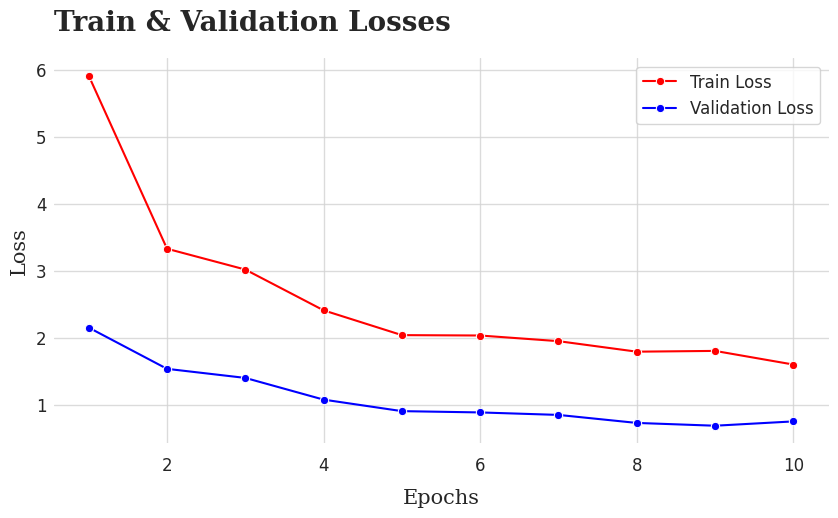

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

epochs_ = range(1, num_epochs + 1)
sns.set_theme(style="whitegrid")

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.lineplot(x=epochs_, y=history["train_loss"], color="red", marker="o", label="Train Loss", zorder=2, ax=ax)
sns.lineplot(x=epochs_, y=history["val_loss"], color="blue", marker="o", label="Validation Loss", zorder=2, ax=ax)

ax.set_title("Train & Validation Losses", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.05)
ax.set_xlabel("Epochs", fontsize=15, fontfamily="serif", labelpad=10)
ax.set_ylabel("Loss", fontsize=15, fontfamily="serif", labelpad=5)
ax.xaxis.set_tick_params(labelsize=12, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.legend(fontsize=12, loc="best")

for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

plt.show()

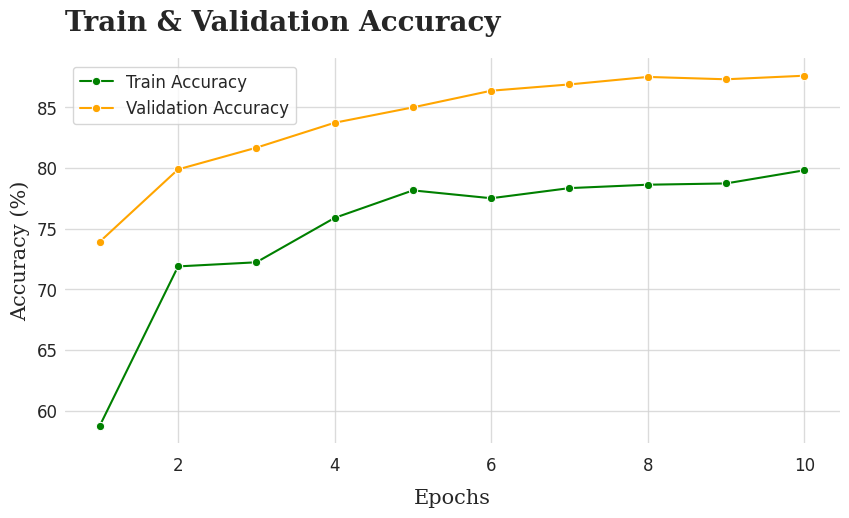

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.lineplot(x=epochs_, y=[a * 100 for a in history["train_acc"]], color="green", marker="o", label="Train Accuracy", zorder=2, ax=ax)
sns.lineplot(x=epochs_, y=[a * 100 for a in history["val_acc"]], color="orange", marker="o", label="Validation Accuracy", zorder=2, ax=ax)

ax.set_title("Train & Validation Accuracy", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.05)
ax.set_xlabel("Epochs", fontsize=15, fontfamily="serif", labelpad=10)
ax.set_ylabel("Accuracy (%)", fontsize=15, fontfamily="serif", labelpad=5)
ax.xaxis.set_tick_params(labelsize=12, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.legend(fontsize=12, loc="best")

for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

plt.show()

In [ ]:
test_loss, test_acc = validate_one_epoch(alexnet, test_loader, criterion, device)
print(f"\n✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")



✅ Test Loss: 0.8007
✅ Test Accuracy: 86.39%


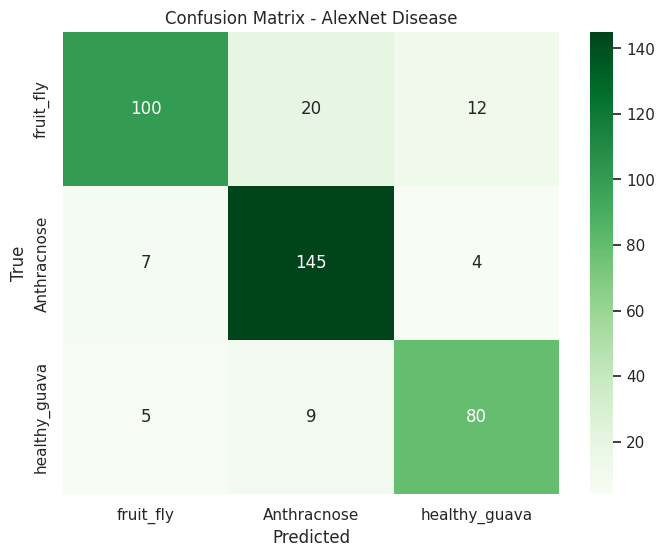

               precision    recall  f1-score   support

    fruit_fly       0.89      0.76      0.82       132
  Anthracnose       0.83      0.93      0.88       156
healthy_guava       0.83      0.85      0.84        94

     accuracy                           0.85       382
    macro avg       0.85      0.85      0.85       382
 weighted avg       0.85      0.85      0.85       382



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

alexnet.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        images = batch["images"].to(device, dtype=torch.float)
        labels = batch["labels"].to(device)
        outputs = alexnet(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=train_dataset.labels,
            yticklabels=train_dataset.labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - AlexNet Disease")
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=train_dataset.labels))